In [1]:
!pip install tensorflow[and-cuda]==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 75.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 61.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [2]:
# To make sure we are using gpu not cpu
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2024-09-15 17:54:40.141171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 17:54:40.141226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 17:54:40.142724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix

In [4]:
tf.__version__

'2.15.1'

In [5]:
datagen = ImageDataGenerator(rescale = 1./255)

In [6]:

train = datagen.flow_from_directory('/kaggle/input/breast-mammography-private/train', target_size=(224, 224), class_mode='binary', batch_size=256)
# load and iterate validation dataset
# val = datagen.flow_from_directory('/kaggle/input/breast-mammography-ori/public/val', target_size=(224, 224), class_mode='binary', batch_size=16)
# load and iterate test dataset
test = datagen.flow_from_directory('/kaggle/input/breast-mammography-private/test', target_size=(224, 224), class_mode='binary', batch_size=8)

Found 3132 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [7]:
STEP_SIZE_TRAIN = train.n//train.batch_size
STEP_SIZE_VAL = test.n//test.batch_size

In [8]:
steps = test.n//test.batch_size

test.reset()
X_test, y_test = [], []
for i in range(steps+1):
    a , b = test.next()
    X_test.extend(a) 
    y_test.extend(b)

In [9]:
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(131, 224, 224, 3) (131,)


In [10]:
from keras.applications.vgg16 import VGG16

In [11]:
def get_compiled_model():
    backbone2 = VGG16(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    backbone2.trainable = True
    set_trainable = False
    for layer in backbone2.layers:
        if layer.name == 'block4_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    VGG_model_2 = Sequential()
    VGG_model_2.add(backbone2)
    VGG_model_2.add(GlobalAveragePooling2D())
    VGG_model_2.add(BatchNormalization())
    VGG_model_2.add(Dropout(0.5))
    VGG_model_2.add(Dense(1, activation='sigmoid'))
    
    VGG_model_2.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
            metrics=['accuracy']
        )
    
    return VGG_model_2
    

In [12]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 2


In [13]:
with strategy.scope():

    model = get_compiled_model()

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14717249 (56.14 MB)
Trainable params: 1298

In [16]:
history = model.fit(train, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=10)


Epoch 1/10
12/12 [==============================] - 16s 1s/step - loss: 0.0074 - accuracy: 0.9993 - val_loss: 0.1422 - val_accuracy: 0.9297
Epoch 2/10
12/12 [==============================] - 16s 1s/step - loss: 0.0075 - accuracy: 0.9993 - val_loss: 0.1240 - val_accuracy: 0.9375
Epoch 3/10
12/12 [==============================] - 16s 1s/step - loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.1859 - val_accuracy: 0.9219
Epoch 4/10
12/12 [==============================] - 17s 1s/step - loss: 0.0195 - accuracy: 0.9955 - val_loss: 0.1080 - val_accuracy: 0.9766
Epoch 5/10
12/12 [==============================] - 16s 1s/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.1443 - val_accuracy: 0.9297
Epoch 6/10
12/12 [==============================] - 16s 1s/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.1178 - val_accuracy: 0.9688
Epoch 7/10
12/12 [==============================] - 17s 1s/step - loss: 0.0219 - accuracy: 0.9915 - val_loss: 0.1166 - val_accuracy: 0.9688
Epoch 8/10
12/12 [==

In [17]:
score2 = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')

Test loss: 0.06588699668645859 / Test accuracy: 0.9847328066825867


In [18]:
y_pred_prob_3 = model.predict(X_test)

5/5 [==============================] - 1s 79ms/step


In [19]:
threshold = 0.5
y_pred_3 = np.where(y_pred_prob_3 > threshold, 1,0)
y_pred_3.squeeze()

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

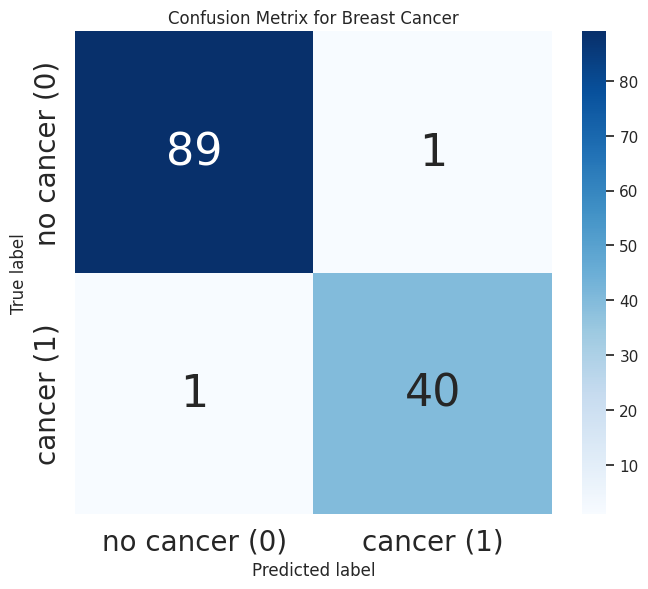

In [20]:
sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred_3),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['no cancer (0)','cancer (1)'], fontsize=20)
plt.yticks([0.50,1.50],['no cancer (0)','cancer (1)'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [21]:
print(classification_report(y_test, y_pred_3, target_names = ['No cancer (Class 0)','cancer (Class 1)']))

                     precision    recall  f1-score   support

No cancer (Class 0)       0.99      0.99      0.99        90
   cancer (Class 1)       0.98      0.98      0.98        41

           accuracy                           0.98       131
          macro avg       0.98      0.98      0.98       131
       weighted avg       0.98      0.98      0.98       131

